<a href="https://colab.research.google.com/github/inbalh1/ML/blob/main/Copy_of_HW1_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW1 - Data Exploration and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection

In [2]:
from matplotlib import pylab
params = {'xtick.labelsize': 18,
 'ytick.labelsize': 18,
 'axes.titlesize' : 22,
 'axes.labelsize' : 20,
 'legend.fontsize': 18,
 'legend.title_fontsize': 22,
 'figure.titlesize': 24
 }
pylab.rcParams.update(params)

## Part 1: Data Loading and First Look


## Loading the dataset

In [3]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

rm: cannot remove '*.csv': No such file or directory
Please load the raw csv data


Saving virus_data.csv to virus_data.csv


In [4]:
dataset = pd.read_csv(filename)

In [ ]:
# (Q1)
dataset.shape

(2500, 28)

In [ ]:
# (Q2)
dataset.num_of_siblings.value_counts()

1.0    786
2.0    553
0.0    544
3.0    318
4.0    120
5.0     34
6.0      9
7.0      1
8.0      1
9.0      1
Name: num_of_siblings, dtype: int64

##Partitioning the data 


In [5]:
# (Q5)
train, test = model_selection.train_test_split(dataset, test_size=0.2, random_state=29)

Correlation is: 0.093


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


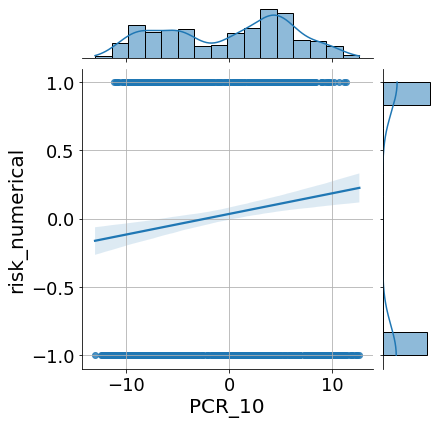

In [16]:
# (Q6)
# Turn risk values to nembers (in  order  to use them)
train['risk_numerical'] = train.risk.map({'High':1, 'Low':-1, np.nan:np.nan})
# plt.grid(alpha=0.5)
x = train.PCR_10
y = train.risk_numerical
# Compute correlation
print("Correlation is: {:.3f}".format(train.corr().risk_numerical.PCR_10))
g = sns.jointplot(train.PCR_10, train.risk_numerical, kind="reg")
_ = g.ax_joint.grid()

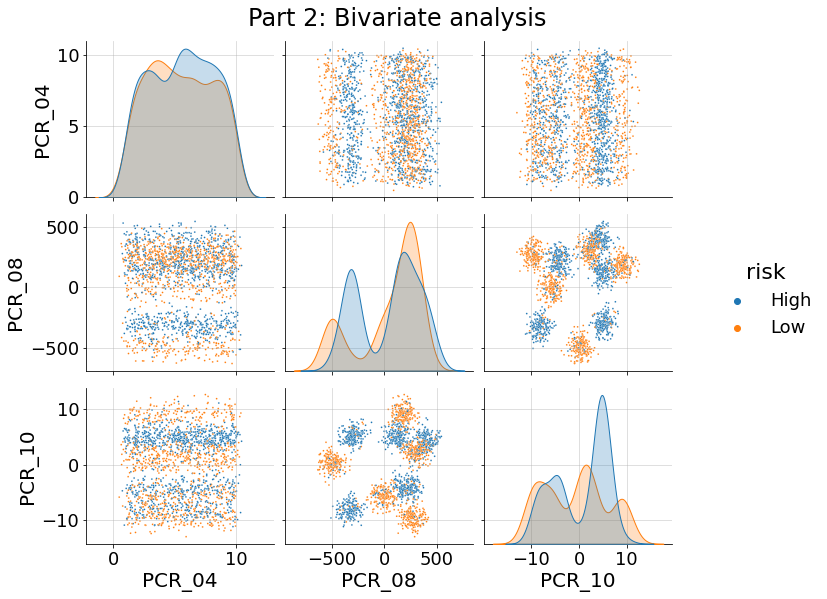

In [23]:
# (Q7)
def draw_pairplot(features, hue, title):
  # The function draws pairplot of two features
  g=sns.pairplot(train, vars=features, hue=hue, plot_kws={"s": 3})
  g.fig.suptitle(title, y=1.04)
  for ax in np.ravel(g.axes):
    ax.grid(alpha=0.5)
  g.fig.set_size_inches(12,8)
draw_pairplot(['PCR_04', 'PCR_08', 'PCR_10'], hue="risk", title="Part 2: Bivariate analysis")

## k-NN implementation

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.spatial.distance import cdist
class kNN(BaseEstimator, ClassifierMixin):

  def __init__(self, n_neighbors:int = 5):
    self.n_neighbors = n_neighbors

  def fit(self, X, y):
    self.X = X
    self.y = y
    return self

  def predict(self, X):
    # Note: You can use self.n_neighbors here
    # Compute the predicted labels (+1 or -1)
    distance = cdist(X, self.X)
    k = self.n_neighbors
    closest_k = np.argpartition(distance, k, axis=1)[:,:k]
    Y = np.ones([X.shape[0], 1]) * np.copy(self.y)
    tmp_res = Y[np.arange(Y.shape[0])[:,None], closest_k]
    predictions = np.sign(tmp_res.sum(axis=1))
    return predictions

In [ ]:
"""partial = train[['PCR_08', 'PCR_10']].copy()
x = partial.head(3)
distance = cdist(x, partial)
k = 2
closest_k = np.argpartition(distance, k, axis=1)[:,:k]
y = np.ones([x.shape[0], 1]) * np.copy(train.risk_numerical)
tmp_res = y[np.arange(y.shape[0])[:,None], closest_k]
np.sign(tmp_res.sum(axis=1))"""

In [8]:
# partial is the data for the KNN
partial = train[['PCR_08', 'PCR_10']].copy()
def get_score_from_knn(k, data):
  h = kNN(k)
  h.fit(data, train.risk_numerical)
  return h.score(data, train.risk_numerical)
print(get_score_from_knn(1,data=partial))
print(get_score_from_knn(9, data=partial))

1.0
0.834


In [9]:
def visualize_clf(clf, X, Y, title, marker_size=150,
                  grid_length=300):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["+", "*"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    #plot_step = 0.02

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip([-1, 1], palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

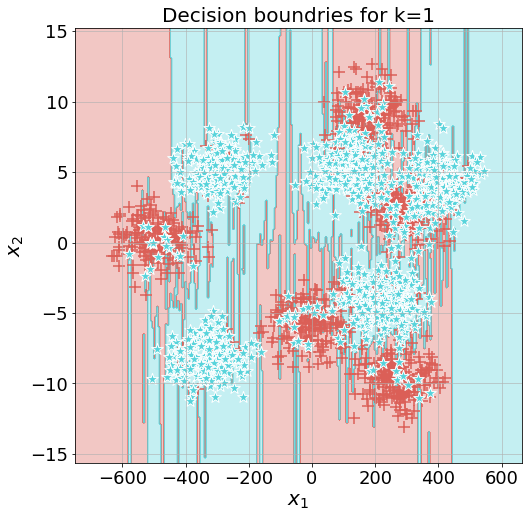

In [ ]:
h = kNN(1)
h.fit(partial, train.risk_numerical)
X = train.loc[:, ['PCR_08', 'PCR_10']].to_numpy()
y = train.loc[:, ['risk_numerical']].to_numpy()
visualize_clf(h, X, y, "Decision boundries for k=1")

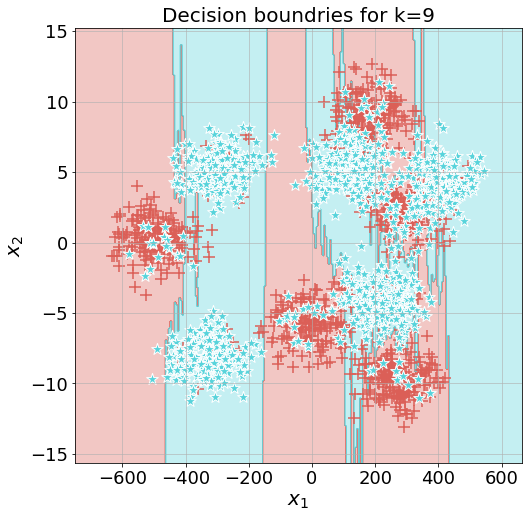

In [ ]:
h = kNN(9)
h.fit(partial, train.risk_numerical)
X = train.loc[:, ['PCR_08', 'PCR_10']].to_numpy()
y = train.loc[:, ['risk_numerical']].to_numpy()
visualize_clf(h, X, y, "Decision boundries for k=9")

# Data Normalization


In [ ]:
partial.min(axis=0)

In [ ]:
# (Q9)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(partial)
print(get_score_from_knn(k=1, data=scaled_data))
print(get_score_from_knn(k=9, data=scaled_data))

In [ ]:
h = kNN(1)
h.fit(scaled_data, train.risk_numerical)
y = train.loc[:, ['risk_numerical']].to_numpy()
visualize_clf(h, scaled_data, y, "Decision boundries for k=1")

In [ ]:
h = kNN(9)
h.fit(scaled_data, train.risk_numerical)
y = train.loc[:, ['risk_numerical']].to_numpy()
visualize_clf(h, scaled_data, y, "Decision boundries for k=9")

# Part 3: Data Exploration


In [ ]:
# (Q11)
pd.get_dummies(data=train, columns=["blood_type"])

,patient_id,age,sex,weight,address,current_location,num_of_siblings,happiness_score,household_income,conversations_per_day,...,spread,covid,blood_type_A+,blood_type_A-,blood_type_AB+,blood_type_AB-,blood_type_B+,blood_type_B-,blood_type_O+,blood_type_O-
921,1726,33.0,F,55.9,USCGC Mclean\nFPO AA 61590,"('10.22677', '-67.33122')",0.0,7.0,343.30,5.0,...,Low,False,0,0,0,0,0,0,1,0
2438,7309,40.0,F,73.7,"7888 Katherine Bridge\nSylviastad, SC 30447",NaN,2.0,7.0,32.40,2.0,...,High,True,0,0,0,0,1,0,0,0
2457,5704,8.0,F,41.9,"44718 Michael Squares\nNew Heather, HI 51592","('58.63667', '59.80222')",1.0,9.0,486.60,5.0,...,High,True,0,0,0,0,1,0,0,0
1124,3822,26.0,M,113.8,"97186 Melanie Lodge Apt. 376\nLake Philipberg,...",NaN,2.0,8.0,384.30,6.0,...,High,False,0,0,0,0,0,0,1,0
1219,57,28.0,M,53.7,USS Faulkner\nFPO AP 36758,"('17.30858', '97.01124')",2.0,8.0,618.12,0.0,...,Low,True,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1393,4126,3.0,M,34.7,0832 Conley Avenue Suite 092\nPort Bernardstad...,"('-2.90055', '-79.00453')",0.0,6.0,613.30,0.0,...,Low,True,0,0,0,0,1,0,0,0
2409,4683,24.0,F,48.1,"367 Matthew Harbor Apt. 835\nBillyburgh, IL 83131","('-8.99167', '125.21972')",1.0,7.0,427.20,4.0,...,Low,True,0,0,0,0,0,0,1,0
864,4412,36.0,NaN,77.7,"18001 Holmes Creek Apt. 253\nNorth Victoria, M...","('45.16024', '-93.08883')",1.0,7.0,NaN,3.0,...,High,True,1,0,0,0,0,0,0,0
808,6090,3.0,M,23.8,"75734 Bryan Causeway\nNorth Stephen, MD 25076","('33.03699', '-117.29198')",1.0,8.0,857.00,3.0,...,Low,True,0,0,0,0,0,0,1,0


In [ ]:
# (Q12)
for symptom in ["cough", "low_appetite", "sore_throat", "fever", "shortness_of_breath"]:
  train[symptom] = train.symptoms.str.contains(symptom).map({True:1, False:0, np.nan:np.nan})
train.head()

,patient_id,age,sex,weight,blood_type,address,current_location,num_of_siblings,happiness_score,household_income,...,PCR_09,PCR_10,risk,spread,covid,cough,low_appetite,sore_throat,fever,shortness_of_breath
921,1726,33.0,F,55.9,O+,USCGC Mclean\nFPO AA 61590,"('10.22677', '-67.33122')",0.0,7.0,343.30,...,-8.431349,3.682026,High,Low,False,NaN,NaN,NaN,NaN,NaN
2438,7309,40.0,F,73.7,B+,"7888 Katherine Bridge\nSylviastad, SC 30447",NaN,2.0,7.0,32.40,...,-22.091340,5.276248,High,High,True,0.0,1.0,0.0,0.0,0.0
2457,5704,8.0,F,41.9,B+,"44718 Michael Squares\nNew Heather, HI 51592","('58.63667', '59.80222')",1.0,9.0,486.60,...,-15.573490,9.418958,Low,High,True,NaN,NaN,NaN,NaN,NaN
1124,3822,26.0,M,113.8,O+,"97186 Melanie Lodge Apt. 376\nLake Philipberg,...",NaN,2.0,8.0,384.30,...,-0.342635,3.491480,High,High,False,NaN,NaN,NaN,NaN,NaN
1219,57,28.0,M,53.7,A+,USS Faulkner\nFPO AP 36758,"('17.30858', '97.01124')",2.0,8.0,618.12,...,-10.121844,2.724149,High,Low,True,NaN,NaN,NaN,NaN,NaN


In [ ]:
# (Q13)
train = pd.get_dummies(data=train, columns=['sex'])

In [ ]:
train.address.str.split("\n", expand=True)[1].str.split(",", expand=True)[1].str.split(" ", expand=True)[1].value_counts().sum()

1677

In [ ]:
train.address.str.split(" ", expand=True)[-1]

KeyError: ignored

In [ ]:
train.address.str.split(",", expand=True)[1].str.split(" ",expand=True)[1].value_counts()

Box    75
SC     43
WA     41
VA     41
AK     41
CT     41
IL     39
WY     39
HI     39
MN     39
NY     38
NE     37
ME     37
MI     37
AZ     36
CA     36
VT     35
ID     35
WI     35
UT     35
OH     35
IA     35
GA     35
ND     35
NC     34
AL     34
WV     34
OK     33
MT     33
MS     33
TX     33
NJ     32
AR     32
FL     32
KS     32
NV     31
MO     31
PA     31
IN     30
TN     30
MD     29
SD     28
OR     28
NM     26
KY     26
DE     26
LA     26
RI     24
CO     23
MA     23
NH     21
DC     18
Name: 1, dtype: int64

In [ ]:
train.columns

Index(['patient_id', 'age', 'weight', 'blood_type', 'address',
       'current_location', 'num_of_siblings', 'happiness_score',
       'household_income', 'conversations_per_day', 'sugar_levels',
       'sport_activity', 'symptoms', 'pcr_date', 'PCR_01', 'PCR_02', 'PCR_03',
       'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10',
       'risk', 'spread', 'covid', 'risk_numerical', 'cough', 'low_appetite',
       'sore_throat', 'fever', 'shortness_of_breath', 'sex_F', 'sex_M'],
      dtype='object')

In [20]:
# (Q14)
# TODO: add state, current location coordinates, maybe pcr_date as well (since it looks bad)
# TODO2: What about the blood type? Should we use the numerical one?
COL_NAME = ['age', 'weight', 'blood_type', 'num_of_siblings', 'happiness_score',
            'household_income', 'conversations_per_day', 'sugar_levels',
            'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03',
            'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10',
            'cough', 'low_appetite', 'sore_throat', 'fever', 'shortness_of_breath',
            'sex_F', 'sex_M', 'pcr_date']
KDE_FEATURES = ['age', 'weight', 'num_of_siblings', 'happiness_score',
            'household_income', 'conversations_per_day', 'sugar_levels',
            'sport_activity', 'PCR_01', 'PCR_02', 'PCR_03',
            'PCR_04', 'PCR_05', 'PCR_06', 'PCR_07', 'PCR_08', 'PCR_09', 'PCR_10']
COLS = 2
ROWS = len(COL_NAME)

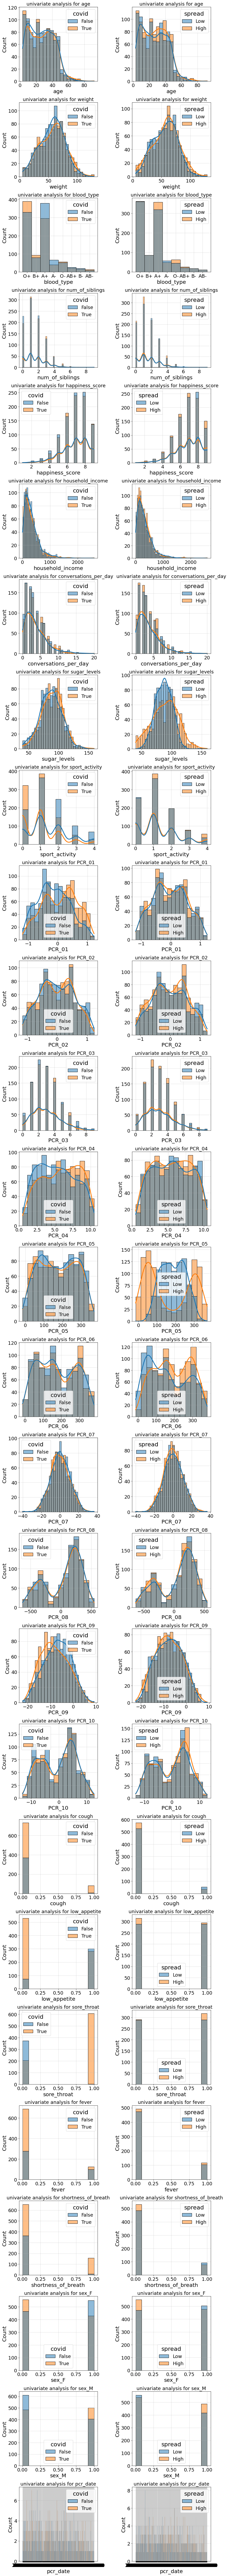

In [ ]:
# (Q14 - continue)
plt.figure(figsize=(6 * COLS, 5 * ROWS))

for row in range(ROWS):
  column = COL_NAME[row]
  ax = plt.subplot(ROWS,COLS, row * COLS + 1)
  ax.set_title("univariate analysis for " + column, fontsize=18)
  sns.histplot(data=train, x=column, hue="covid", line_kws={"linewidth": 3},
  kde=(column in KDE_FEATURES))
  plt.grid(alpha=0.5)
  plt.subplot(ROWS,COLS, row * COLS + 2)
  ax2 = sns.histplot(data=train, x=column, hue="spread", line_kws={"linewidth": 3},
  kde=(column in KDE_FEATURES))
  ax2.set_title("univariate analysis for " + column, fontsize=18)
  plt.grid(alpha=0.5)
plt.tight_layout()


In [21]:
# (Q15)
# TODO: As well as in Q14, should compute again  after transforming features to numerical vals
train["spread_numerical"] = train.spread.map({'High':1, 'Low':0, np.nan:np.nan})
s = train.corr().spread_numerical.abs()
s.sort_values(kind="quicksort", ascending=False)

spread_numerical         1.000000
PCR_06                   0.135714
PCR_05                   0.113222
sugar_levels             0.057766
PCR_10                   0.037096
weight                   0.031790
PCR_07                   0.029934
sport_activity           0.027804
PCR_09                   0.027635
PCR_02                   0.024631
risk_numerical           0.024157
age                      0.022896
PCR_04                   0.015864
patient_id               0.012266
conversations_per_day    0.008138
PCR_03                   0.007953
happiness_score          0.007556
covid                    0.004407
PCR_08                   0.003926
household_income         0.002651
PCR_01                   0.000643
num_of_siblings          0.000233
Name: spread_numerical, dtype: float64

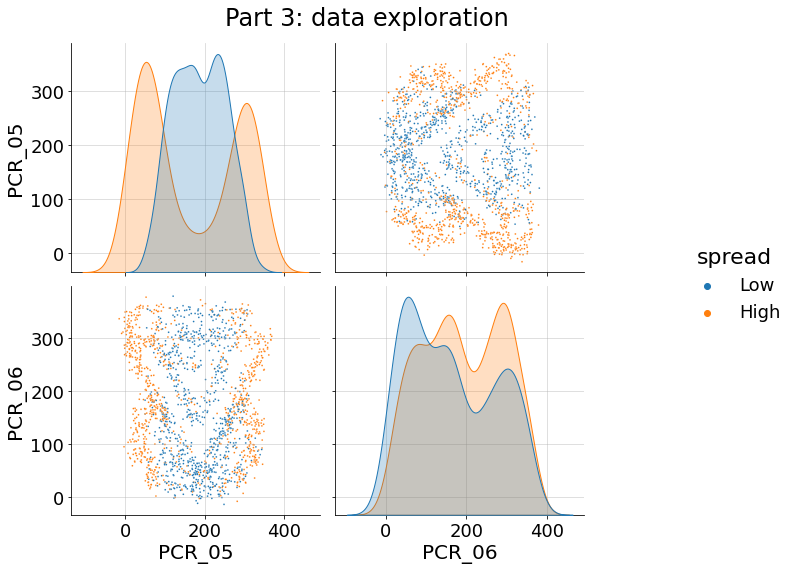

In [30]:
# (Q16)
# Draw the 2 best features only
draw_pairplot(["PCR_05", "PCR_06"], hue="spread", title="Part 3: data exploration")

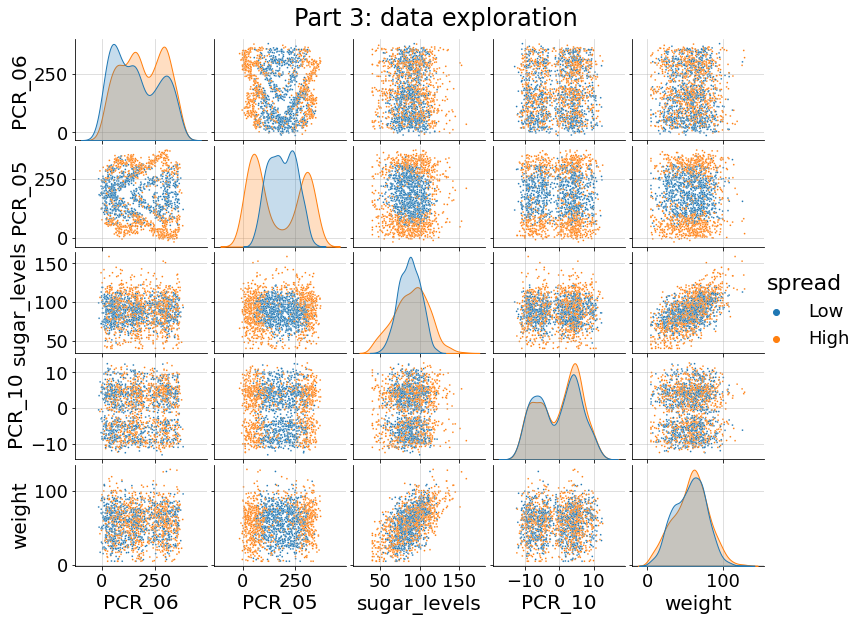

In [28]:
# Get names of 5 features with best correlation to spread
top_features = list(s.sort_values(kind="quicksort", ascending=False)[1:6].index)
# draw pairplot for each two of these features
draw_pairplot(top_features, hue="spread", title="Part 3: data exploration")

# How to download from Colab?

In [ ]:
from google.colab import files
outputPath = "saved_file.csv"
dataset.to_csv(outputPath)
files.download(outputPath) 

In [ ]:
df = dataset

In [ ]:
df.dtypes


In [ ]:
df.head()
df.sugar_levels.head()

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             2500 non-null   int64  
 1   age                    2381 non-null   float64
 2   sex                    2364 non-null   object 
 3   weight                 2367 non-null   float64
 4   blood_type             2359 non-null   object 
 5   address                2372 non-null   object 
 6   current_location       2382 non-null   object 
 7   num_of_siblings        2367 non-null   float64
 8   happiness_score        2389 non-null   float64
 9   household_income       2374 non-null   float64
 10  conversations_per_day  2392 non-null   float64
 11  sugar_levels           2376 non-null   float64
 12  sport_activity         2367 non-null   float64
 13  symptoms               1490 non-null   object 
 14  pcr_date               2382 non-null   object 
 15  PCR_

In [ ]:
df.describe()

,patient_id,age,weight,num_of_siblings,happiness_score,household_income,conversations_per_day,sugar_levels,sport_activity,PCR_01,PCR_02,PCR_03,PCR_04,PCR_05,PCR_06,PCR_07,PCR_08,PCR_09,PCR_10
count,2500.000000,2381.000000,2367.000000,2367.000000,2389.000000,2374.000000,2392.000000,2376.000000,2367.000000,2374.000000,2392.000000,2394.000000,2500.000000,2364.000000,2385.000000,2384.000000,2500.000000,2386.000000,2500.000000
mean,4007.751600,26.596808,56.952514,1.509928,6.945584,314.103151,3.516722,88.130471,1.238699,-0.028715,-0.006145,2.948204,5.533616,176.404966,177.557247,0.044754,47.028588,-7.540962,-0.194871
std,2297.317303,15.541716,21.776503,1.259204,1.475218,262.534208,2.899352,18.137737,1.096782,0.564384,0.570868,1.751792,2.629841,99.086902,104.989169,10.144631,297.335672,5.921984,6.207290
min,4.000000,3.000000,5.000000,0.000000,1.000000,1.000000,0.000000,40.000000,0.000000,-1.214815,-1.198200,0.000000,0.483812,-15.421751,-13.209828,-40.135782,-631.386211,-22.212634,-13.058805
25%,2037.750000,12.000000,40.800000,1.000000,6.000000,126.350000,1.000000,76.000000,0.000000,-0.453289,-0.440806,2.000000,3.261151,89.454266,83.653686,-6.965020,-255.925103,-11.955739,-5.769724
50%,4026.000000,26.000000,58.900000,1.000000,7.000000,246.130000,3.000000,89.000000,1.000000,-0.041253,-0.012019,3.000000,5.554198,174.394817,167.565046,0.007104,153.665127,-7.683597,1.101015
75%,5953.500000,40.000000,72.000000,2.000000,8.000000,423.780000,5.000000,100.000000,2.000000,0.418135,0.438873,4.000000,7.796558,261.873421,276.137943,6.853240,274.251721,-3.079536,4.766333
max,8000.000000,92.000000,129.300000,9.000000,9.000000,2593.560000,20.000000,159.000000,4.000000,1.225437,1.231782,9.000000,10.460432,369.575055,379.893012,36.614924,545.623699,9.134072,12.658549


In [ ]:
train.sugar_levels.value_counts()

99.0     45
72.0     45
95.0     45
89.0     44
84.0     44
         ..
132.0     1
145.0     1
143.0     1
159.0     1
153.0     1
Name: sugar_levels, Length: 105, dtype: int64